In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from cfp.preprocessing import transfer_labels, compute_wknn
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [3]:
data_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion"
out_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_downstream"

In [4]:
ood_conditions = ['zc4h2_control_24','met_control_36','tfap2a_control_72','hgfa_control_48','tfap2a_foxd3_72','noto_control_18','cdx4_cdx1a_36','epha4a_control_48','mafba_control_36','tbx16_msgn1_24','noto_control_24','smo_control_18','hand2_control_24','noto_control_36','egr2b_control_36','cdx4_control_18','tfap2a_control_36','foxi1_control_72','egr2b_control_24','cdx4_control_36','zc4h2_control_36','hoxb1a_control_48','tfap2a_foxd3_36','tbx16_tbx16l_24','smo_control_36','mafba_control_18','hgfa_control_72','tbx16_control_18','mafba_control_24','tbx1_control_36','zc4h2_control_48','wnt3a_wnt8_36','foxi1_control_48','smo_control_24','noto_control_48','mafba_control_48','tfap2a_control_48','hand2_control_48','egr2b_control_48','phox2a_control_48','tbx1_control_48','tbx16_msgn1_36','foxd3_control_72','wnt3a_wnt8_24','egr2b_control_18','wnt3a_wnt8_18','met_control_72','phox2a_control_36','epha4a_control_24','foxd3_control_36','tfap2a_foxd3_48','hand2_control_36','cdx4_cdx1a_24','hgfa_control_36','tbx16_tbx16l_18','tbxta_control_36','cdx4_control_24','foxd3_control_48','met_control_48','tbx1_control_24','epha4a_control_36','cdx4_cdx1a_18','tbx16_control_36','tbx16_tbx16l_36','tbx16_control_24','tbxta_control_24','tbx16_msgn1_18','epha4a_control_18','tbxta_control_18','hoxb1a_control_36','hoxb1a_control_24']
      

In [5]:
spearman_corrs = {}
pearson_corrs = {}
max_logratios = {}
dfs = []
for ood_cond in ood_conditions:
    csv_file = [el for el in os.listdir(data_dir) if ((ood_cond in el) and ("csv" in el))]
    if len(csv_file)==0:
        continue
    assert len(csv_file) == 1
    df = pd.read_csv(os.path.join(data_dir, csv_file[0]))
    spearman_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    max_logratios[ood_cond] = np.abs(df["logratio_true"]).max()
    df["condition"] = f"{ood_cond}"
    dfs.append(df)

In [6]:
df_all = pd.concat(dfs)

In [7]:
df_all.head()

cell_type_broad_transfer  ratio_pred  ratio_true  \
0                              periderm    1.182168    1.349712   
1                    mature fast muscle    1.177825    1.242196   
2  connective tissue-meninges-dermal FB    1.046386    0.899433   
3         neural progenitor (hindbrain)    0.864279    0.775667   
4                    mature slow muscle    0.975546    1.205383   

   logratio_true  logratio_pred         condition  
0       0.432652       0.241436  zc4h2_control_24  
1       0.312892       0.236125  zc4h2_control_24  
2      -0.152912       0.065415  zc4h2_control_24  
3      -0.366491      -0.210431  zc4h2_control_24  
4       0.269492      -0.035718  zc4h2_control_24

In [8]:
brain_cells  =['neural progenitor (hindbrain R7/8)',
 'neurons (differentiating, contains peripheral)',
 'neurons (gabaergic, glutamatergic)',
 'neural progenitor (diencephalon/telencephalon)',
 'neural progenitor (MHB)',
 'neural progenitor (hindbrain)',
 'differentiating neuron 1',
 'differentiating neuron (hindbrain)',
 'floor plate',
 'neuron (cranial ganglion, enteric)',
 'motor neuron (hindbrain, spinal cord)',
 'neural progenitor (telencephalon/diencephalon)',
 'neurons (gabaergic, glutamatergic; contains Purkinje)',
 'neuron (telencephalon, glutamatergic)',
 'KA neuron',
 'neuron (cranial ganglia sensory, Rohon-Beard)',
 'posterior spinal cord progenitors',
 'glia',
 'hypophysis/locus coeruleus',
 'differentiating neuron 2',
 'roof plate, flexural + subcommissural organ',
 'neuron (+ spinal cord)',
 'neuron (dopaminergic)',
 'dorsal spinal cord neuron',
 'unknown (k+ channel, ciliated)']

In [9]:
non_neuron_cells = ['floor plate', 'motor neuron (hindbrain, spinal cord)', 
                    'posterior spinal cord progenitors', 'glia', 'hypophysis/locus coeruleus', 
                    'roof plate, flexural + subcommissural organ', 'neuron (+ spinal cord)',
                    'dorsal spinal cord neuron', 'unknown (k+ channel, ciliated)' ]





In [10]:
neuronal_cells = list(set(brain_cells)-set(non_neuron_cells))

In [11]:
df= df_all[df_all["cell_type_broad_transfer"].isin(neuronal_cells)]

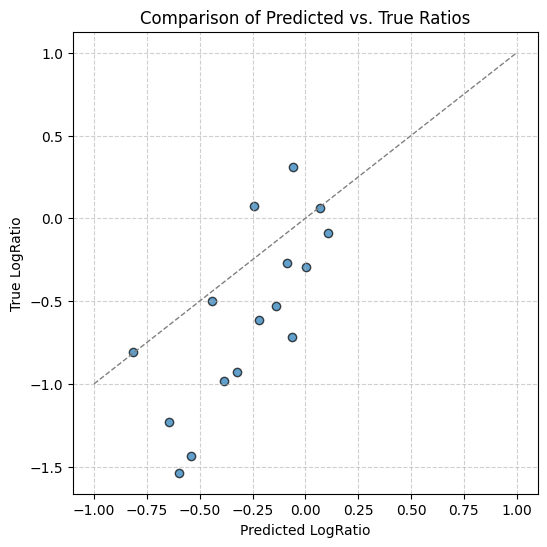

In [13]:
df_red = df[df["condition"]=="cdx4_cdx1a_24"]

plt.figure(figsize=(6, 6))
plt.scatter(df_red["logratio_pred"], df_red["logratio_true"], alpha=0.7, edgecolors='k')

# Add a diagonal reference line (ideal y = x line)
plt.plot([-1, 1], [-1, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)
#plt.xlim(0, 1)
#plt.ylim(0, 1)

plt.show()

In [14]:
df_s = pd.read_csv("/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_sig/significances.csv", index_col=0)

In [15]:
df_s["cell_type_broad"] = df_s.index

In [16]:
def get_significance(x):
    try:
        match = df_s.loc[
            (df_s["cell_type_broad"] == x["cell_type_broad_transfer"]) & 
            (df_s["condition"] == x["condition"]),
            "percentile"
        ]
        
        return match.values[0] if not match.empty else None
    
    except IndexError:
        return None  

df["significance"] = df.apply(get_significance, axis=1)


/tmp/ipykernel_3620107/1648142433.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["significance"] = df.apply(get_significance, axis=1)


In [17]:
df["is_significant"] = df["significance"] < 20.0

/tmp/ipykernel_3620107/1926287962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_significant"] = df["significance"] < 20.0


In [18]:
df["is_significant"].value_counts()

is_significant
False    1021
True      115
Name: count, dtype: int64

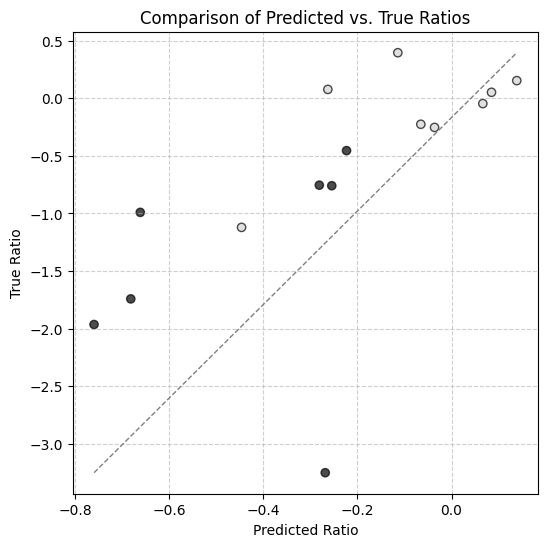

In [19]:


# Subset DataFrame
df_red = df[df["condition"] == "cdx4_cdx1a_18"]

# Assign colors based on significance
colors = np.where(df_red["is_significant"], "black", "lightgray")

# Create figure
plt.figure(figsize=(6, 6))

# Scatter plot with color mapping
plt.scatter(df_red["logratio_pred"], df_red["logratio_true"], alpha=0.7, edgecolors='k', color=colors)

# Add a diagonal reference line
plt.plot(
    [df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].min(), df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].max()],
    [df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].min(), df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].max()],
    linestyle="--",
    color="gray",
    linewidth=1
)

# Labels and title
plt.xlabel("Predicted Ratio")
plt.ylabel("True Ratio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


In [20]:
spearman_corrs = {}
pearson_corrs = {}
dfs = []
for ood_cond in ood_conditions:
    df_tmp = df[df["condition"]=="condition"]
    spearman_corrs[ood_cond] = df_tmp[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df_tmp[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    df_tmp["condition"] = f"{ood_cond}"
    dfs.append(df)

In [21]:
df['timepoint'] = df.apply(lambda x: int(x['condition'].split("_")[-1]), axis=1)

/tmp/ipykernel_3620107/3057663980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timepoint'] = df.apply(lambda x: int(x['condition'].split("_")[-1]), axis=1)


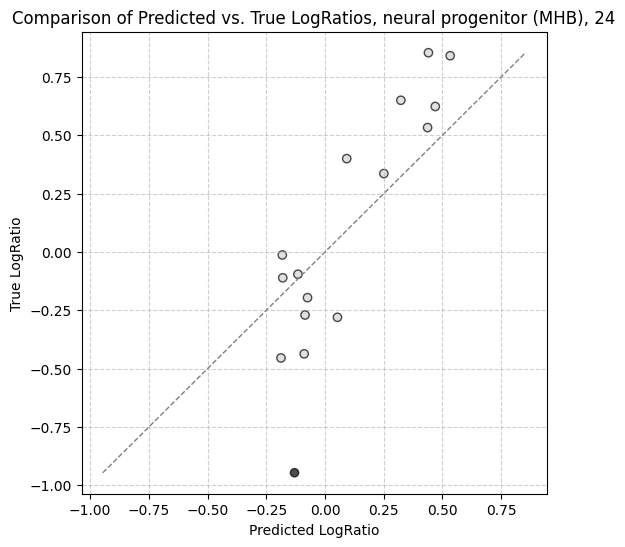

In [22]:
cts_selected = neuronal_cells
timepoint = 24


for cell_type in cts_selected:
    df_red= df[(df["cell_type_broad_transfer"]==cell_type) & (df["timepoint"]==timepoint)]
    
    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")
    
    # Create figure
    plt.figure(figsize=(6, 6))
    
    # Scatter plot with color mapping
    plt.scatter(df_red["logratio_pred"], df_red["logratio_true"], alpha=0.7, edgecolors='k', color=colors)
    
    # Add a diagonal reference line
    minimum = min(df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].min(), df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].min())
    maximum = max(df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].max(), df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].max())
    
    plt.plot(
        [minimum, maximum],
        [minimum, maximum],
        linestyle="--",
        color="gray",
        linewidth=1
    )
    
    # Labels and title
    plt.xlabel("Predicted LogRatio")
    plt.ylabel("True LogRatio")
    plt.title(f"Comparison of Predicted vs. True LogRatios, {cell_type}, {timepoint}")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


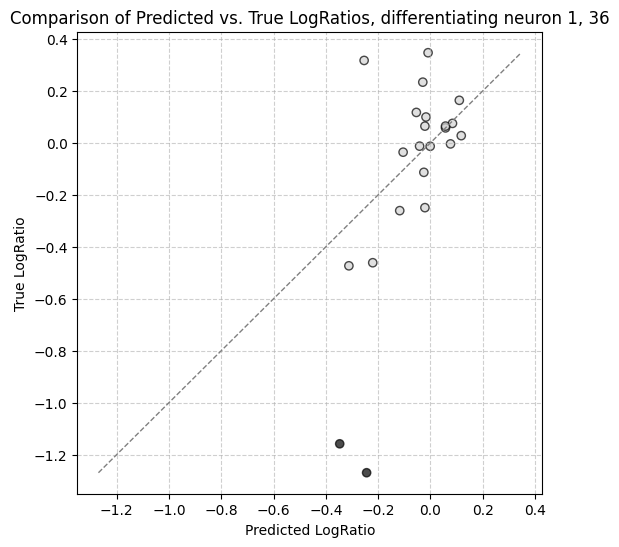

In [23]:
import matplotlib.pyplot as plt
import numpy as np


cell_type = "differentiating neuron 1"
timepoint = 36
df_red= df[(df["cell_type_broad_transfer"]==cell_type) & (df["timepoint"]==timepoint)]

# Assign colors based on significance
colors = np.where(df_red["is_significant"], "black", "lightgray")

# Create figure
plt.figure(figsize=(6, 6))

# Scatter plot with color mapping
plt.scatter(df_red["logratio_pred"], df_red["logratio_true"], alpha=0.7, edgecolors='k', color=colors)

# Add a diagonal reference line
minimum = min(df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].min(), df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].min())
maximum = max(df_red[np.isfinite(df_red["logratio_pred"])]["logratio_pred"].max(), df_red[np.isfinite(df_red["logratio_true"])]["logratio_true"].max())

plt.plot(
    [minimum, maximum],
    [minimum, maximum],
    linestyle="--",
    color="gray",
    linewidth=1
)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title(f"Comparison of Predicted vs. True LogRatios, {cell_type}, {timepoint}")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


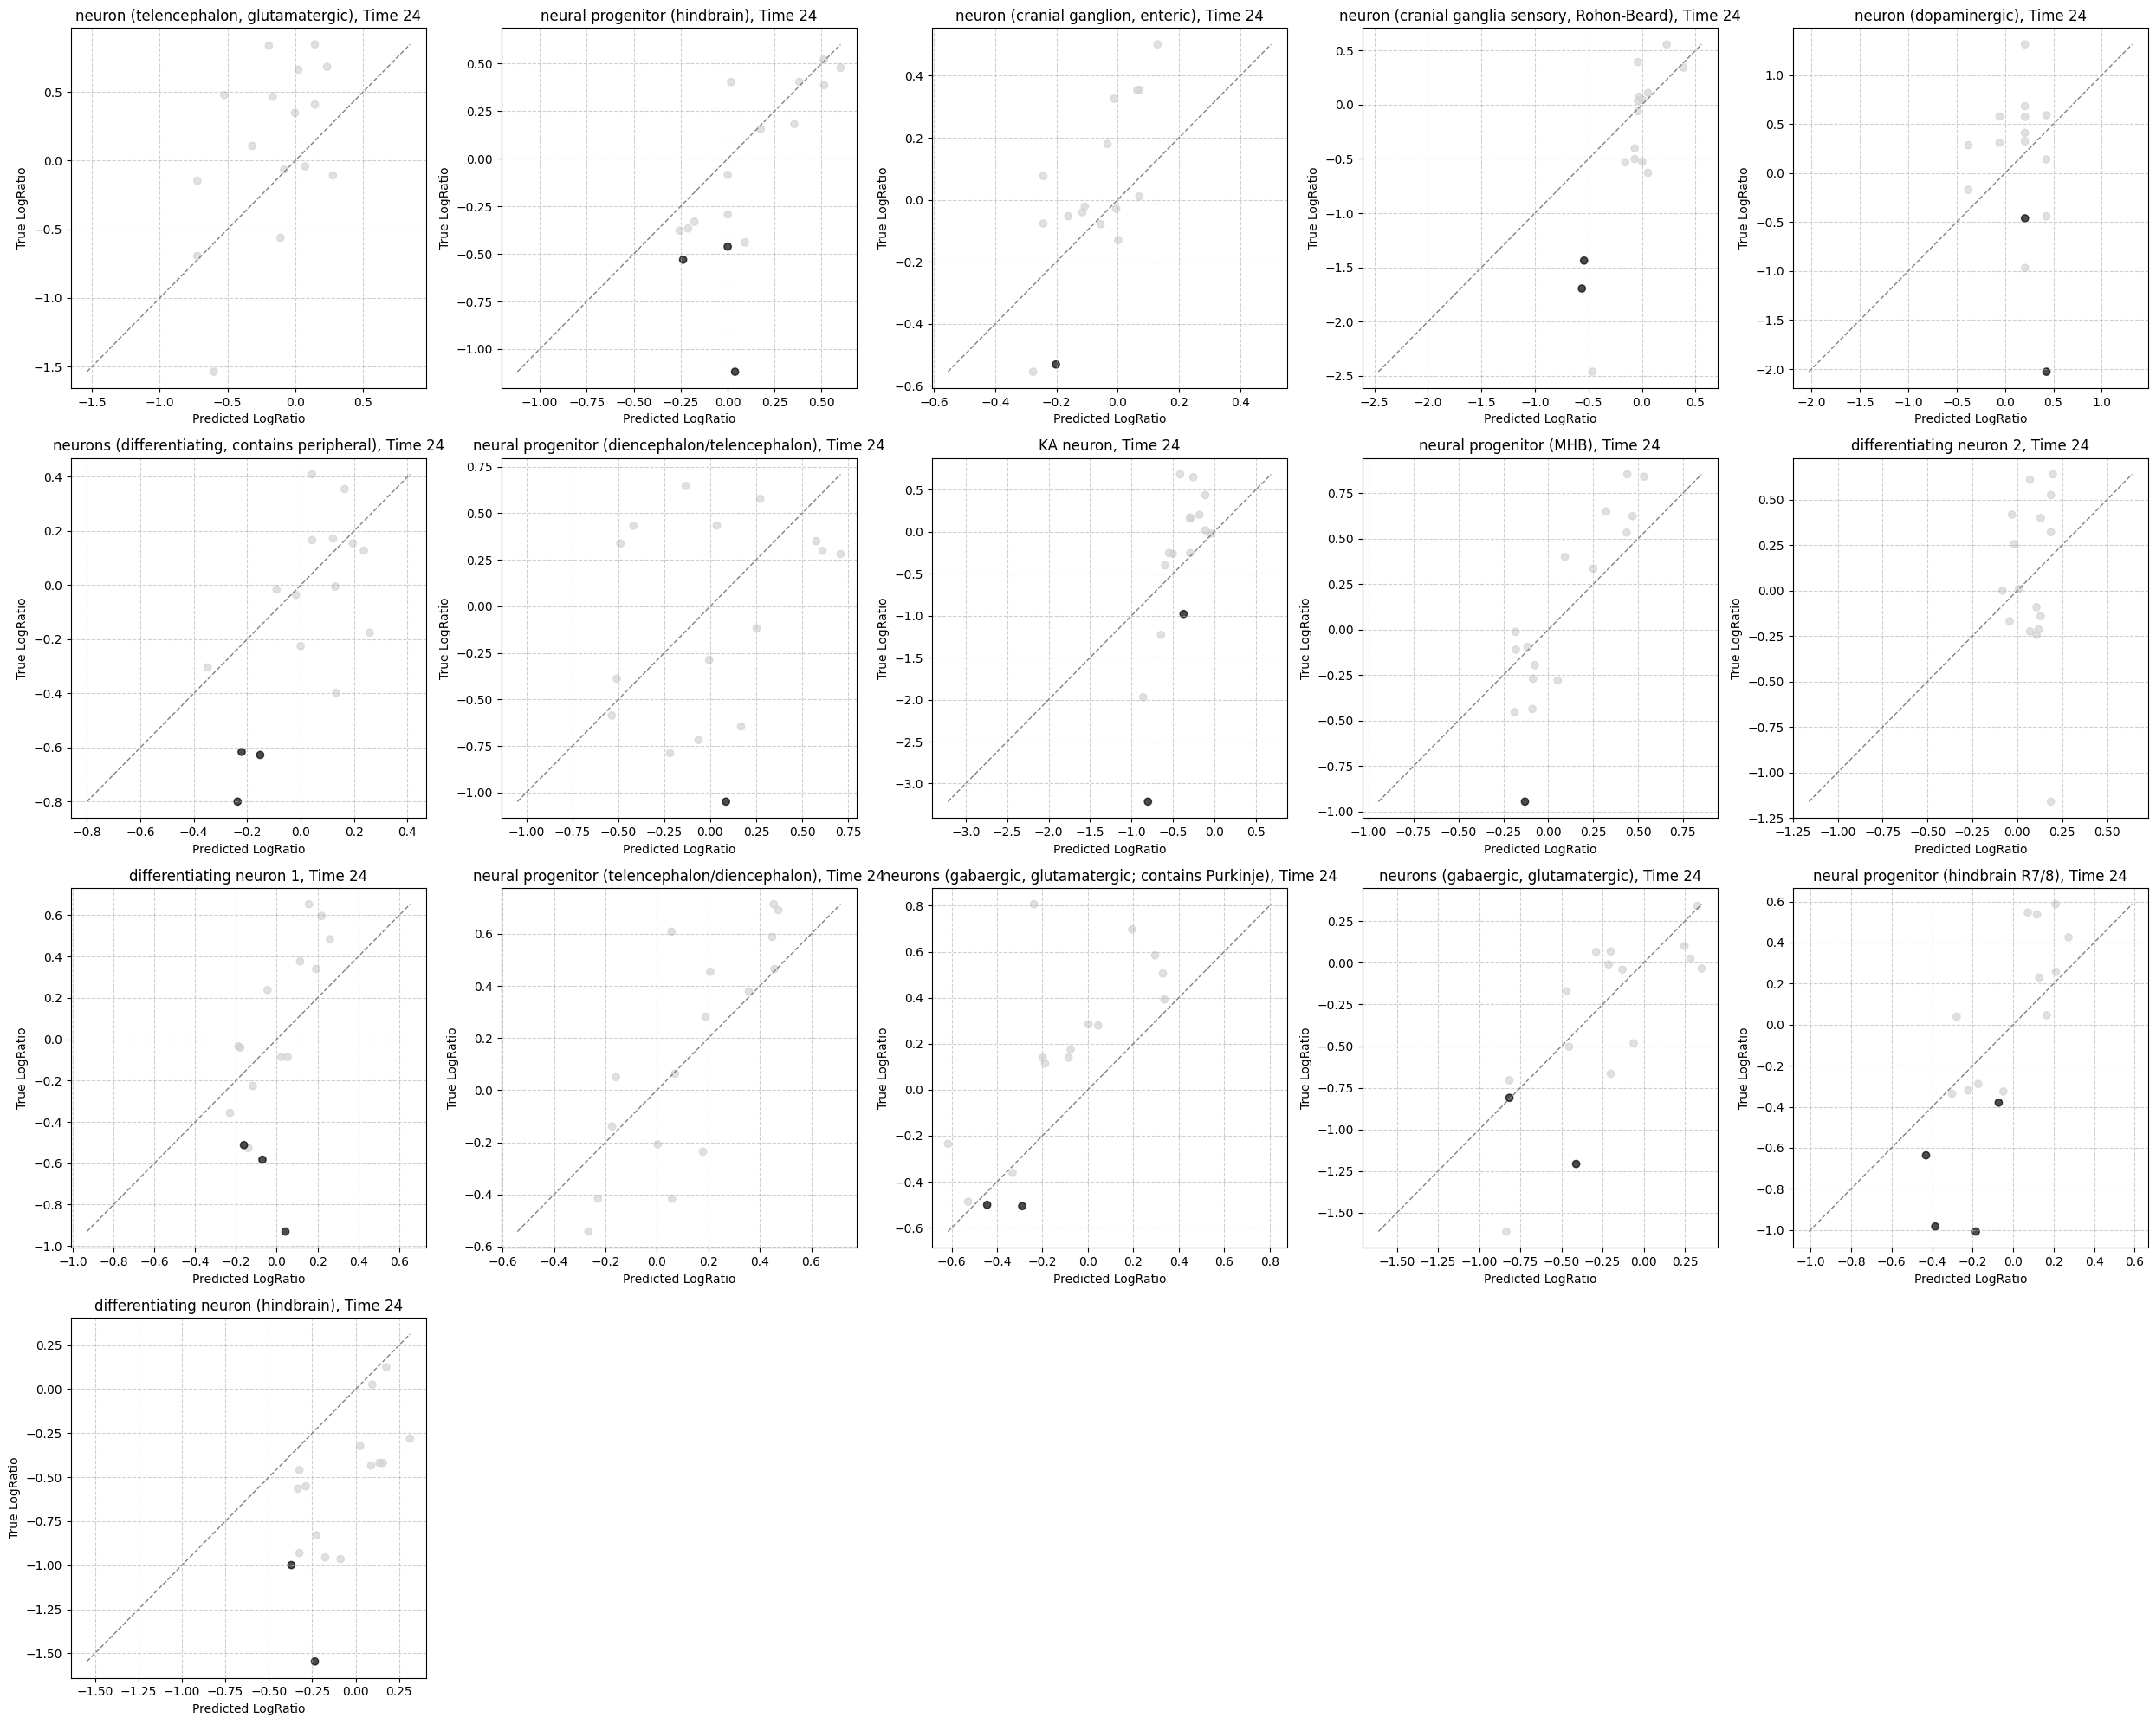

In [25]:
import numpy as np
import matplotlib.pyplot as plt

cts_selected = neuronal_cells
timepoint = 24

# Determine number of rows needed for 5 plots per row
n_plots = len(cts_selected)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Round up division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()  # Flatten axes array for easy iteration

for idx, cell_type in enumerate(cts_selected):
    df_red = df[(df["cell_type_broad_transfer"] == cell_type) & (df["timepoint"] == timepoint)]

    if df_red.empty:
        print(f"No data for {cell_type} at timepoint {timepoint}")
        axes[idx].axis("off")  # Hide empty subplot
        continue

    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")

    # Scatter plot
    axes[idx].scatter(
        df_red["logratio_pred"], df_red["logratio_true"], 
        alpha=0.7, edgecolors="face", c=colors
    )

    # Add diagonal reference line
    finite_pred = df_red["logratio_pred"].replace([np.inf, -np.inf], np.nan).dropna()
    finite_true = df_red["logratio_true"].replace([np.inf, -np.inf], np.nan).dropna()

    if not finite_pred.empty and not finite_true.empty:
        minimum = min(finite_pred.min(), finite_true.min())
        maximum = max(finite_pred.max(), finite_true.max())

        axes[idx].plot(
            [minimum, maximum], [minimum, maximum], 
            linestyle="--", color="gray", linewidth=1
        )

    # Labels and title
    axes[idx].set_xlabel("Predicted LogRatio")
    axes[idx].set_ylabel("True LogRatio")
    axes[idx].set_title(f"{cell_type}, Time {timepoint}")

    # Grid styling
    axes[idx].grid(True, linestyle="--", alpha=0.6)

# Turn off unused subplots (if any)
for i in range(n_plots, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


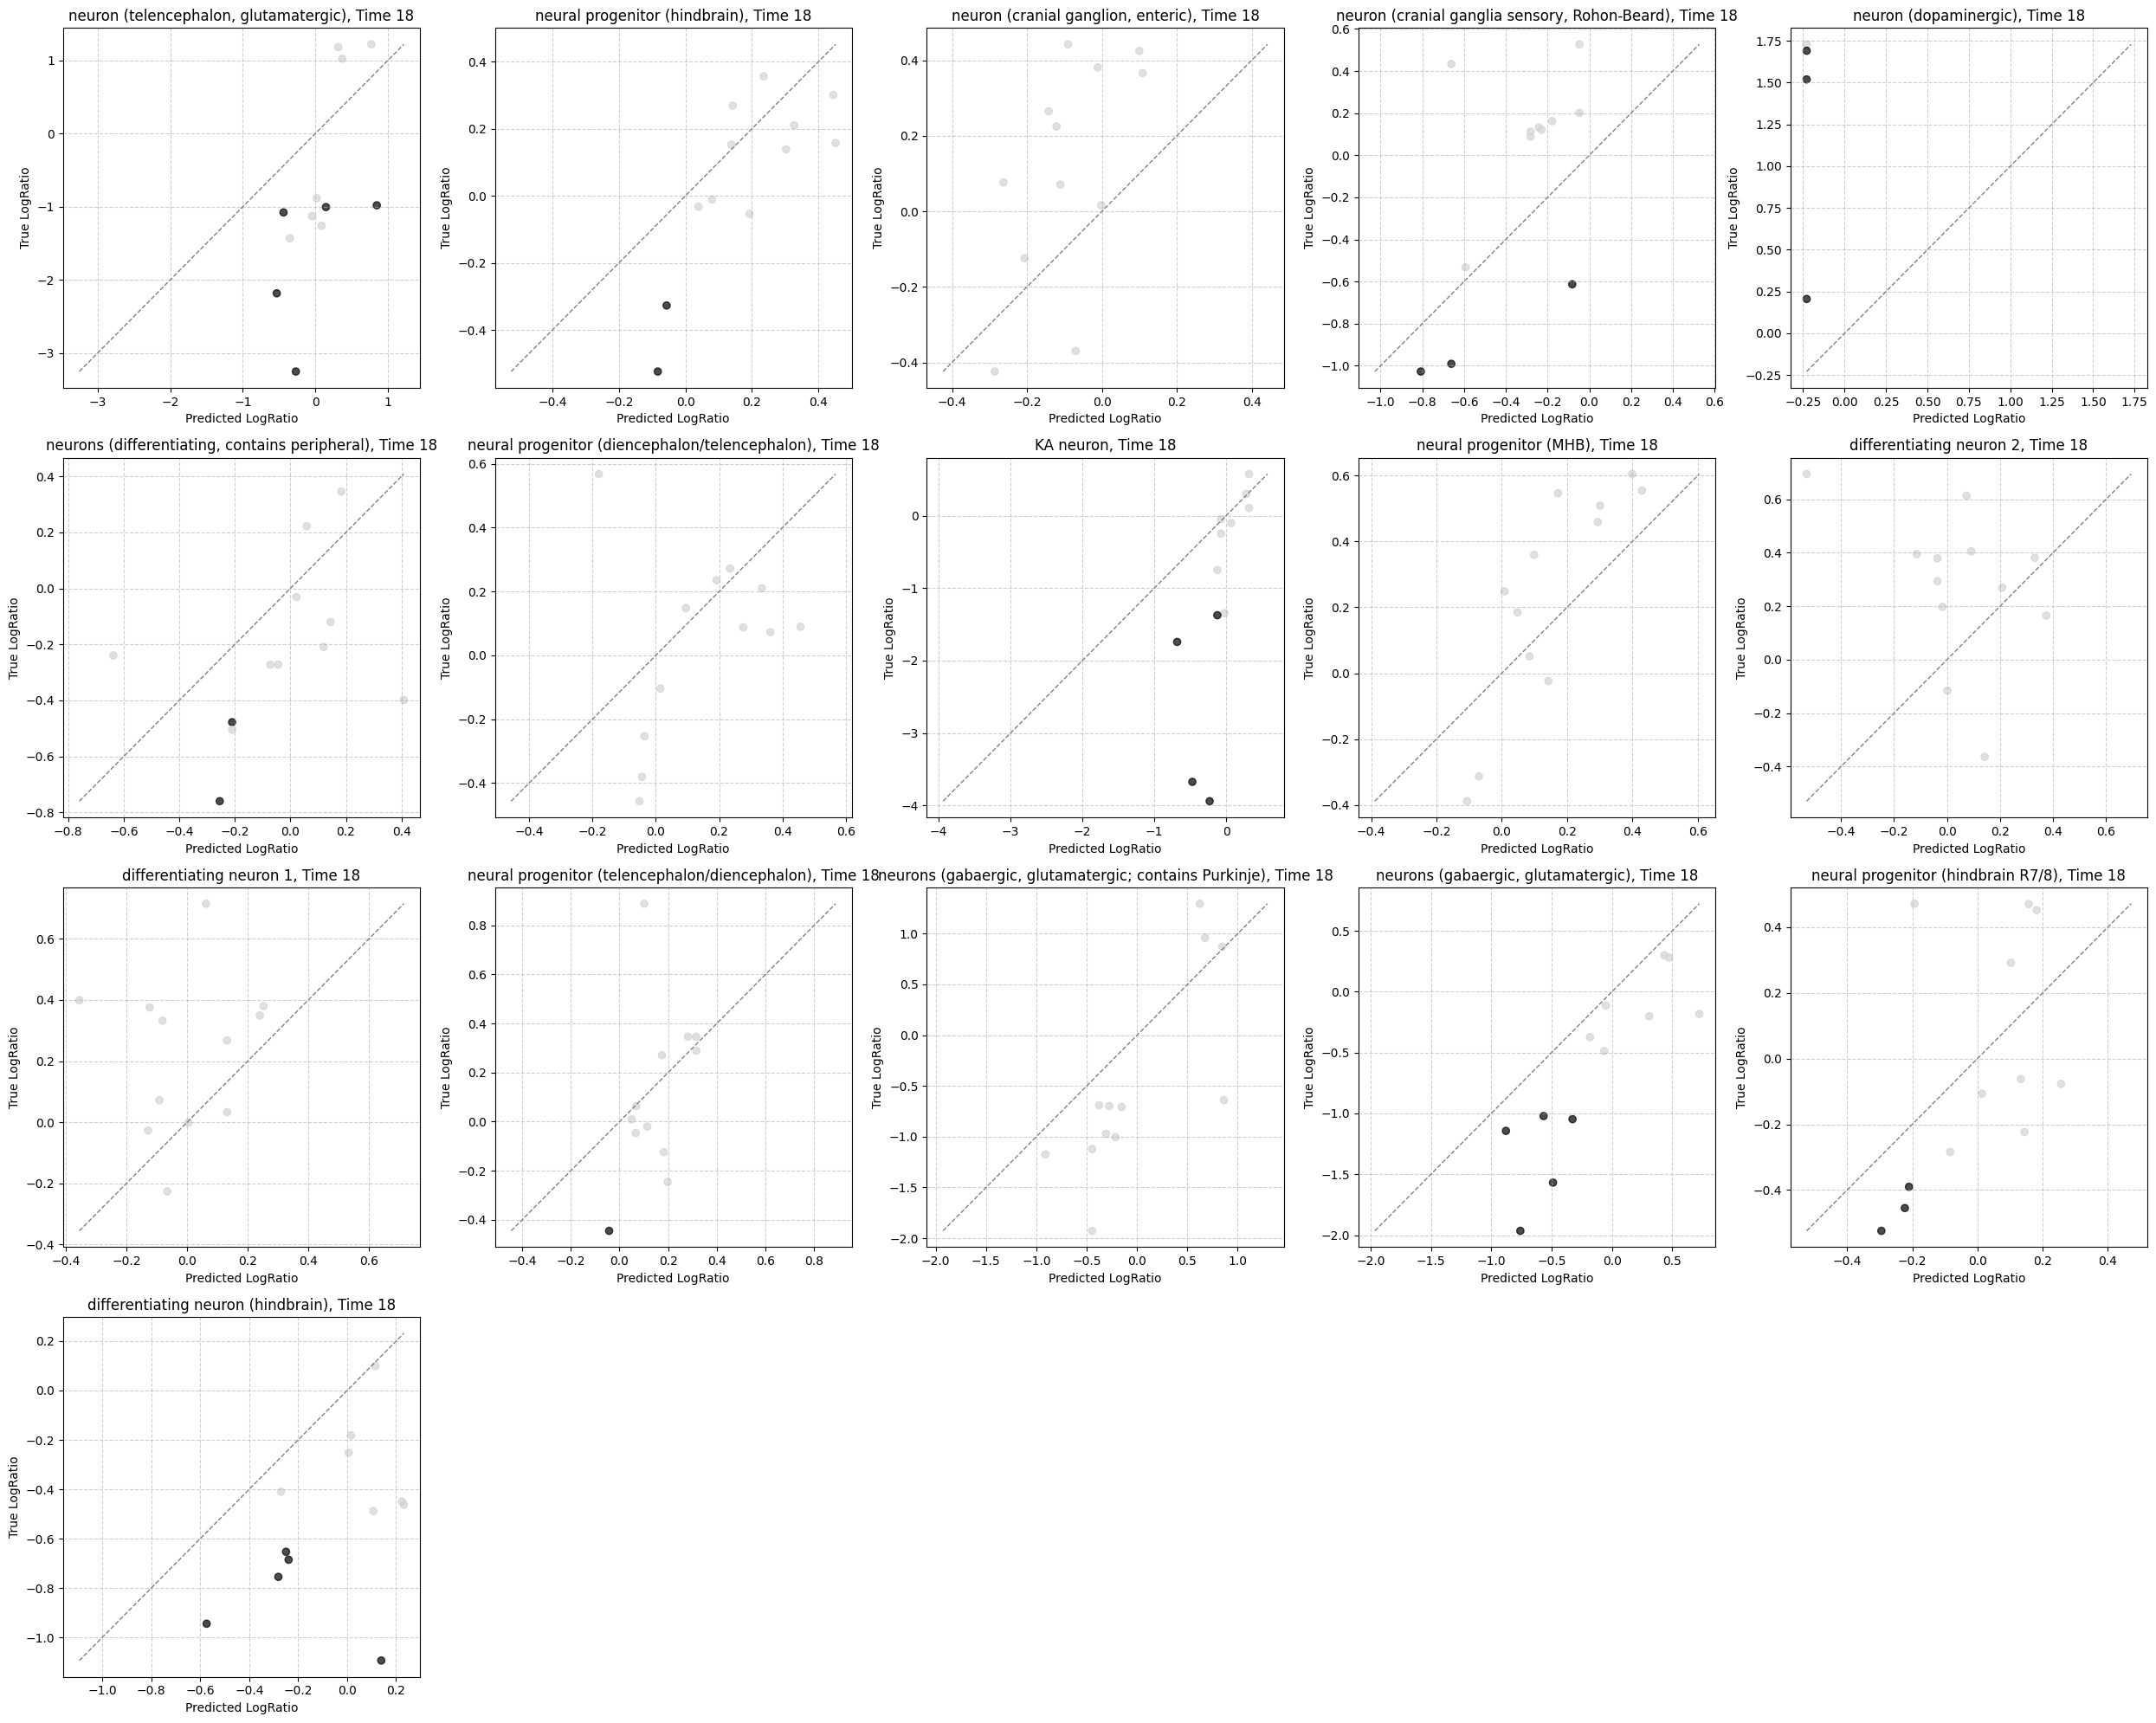

In [26]:
import numpy as np
import matplotlib.pyplot as plt

cts_selected = neuronal_cells
timepoint = 18

# Determine number of rows needed for 5 plots per row
n_plots = len(cts_selected)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Round up division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()  # Flatten axes array for easy iteration

for idx, cell_type in enumerate(cts_selected):
    df_red = df[(df["cell_type_broad_transfer"] == cell_type) & (df["timepoint"] == timepoint)]

    if df_red.empty:
        print(f"No data for {cell_type} at timepoint {timepoint}")
        axes[idx].axis("off")  # Hide empty subplot
        continue

    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")

    # Scatter plot
    axes[idx].scatter(
        df_red["logratio_pred"], df_red["logratio_true"], 
        alpha=0.7, edgecolors="face", c=colors
    )

    # Add diagonal reference line
    finite_pred = df_red["logratio_pred"].replace([np.inf, -np.inf], np.nan).dropna()
    finite_true = df_red["logratio_true"].replace([np.inf, -np.inf], np.nan).dropna()

    if not finite_pred.empty and not finite_true.empty:
        minimum = min(finite_pred.min(), finite_true.min())
        maximum = max(finite_pred.max(), finite_true.max())

        axes[idx].plot(
            [minimum, maximum], [minimum, maximum], 
            linestyle="--", color="gray", linewidth=1
        )

    # Labels and title
    axes[idx].set_xlabel("Predicted LogRatio")
    axes[idx].set_ylabel("True LogRatio")
    axes[idx].set_title(f"{cell_type}, Time {timepoint}")

    # Grid styling
    axes[idx].grid(True, linestyle="--", alpha=0.6)

# Turn off unused subplots (if any)
for i in range(n_plots, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


In [27]:
cts_red= ['neural progenitor (hindbrain)',
 'neural progenitor (hindbrain R7/8)',
 'differentiating neuron (hindbrain)',
 'neural progenitor (telencephalon/diencephalon)']

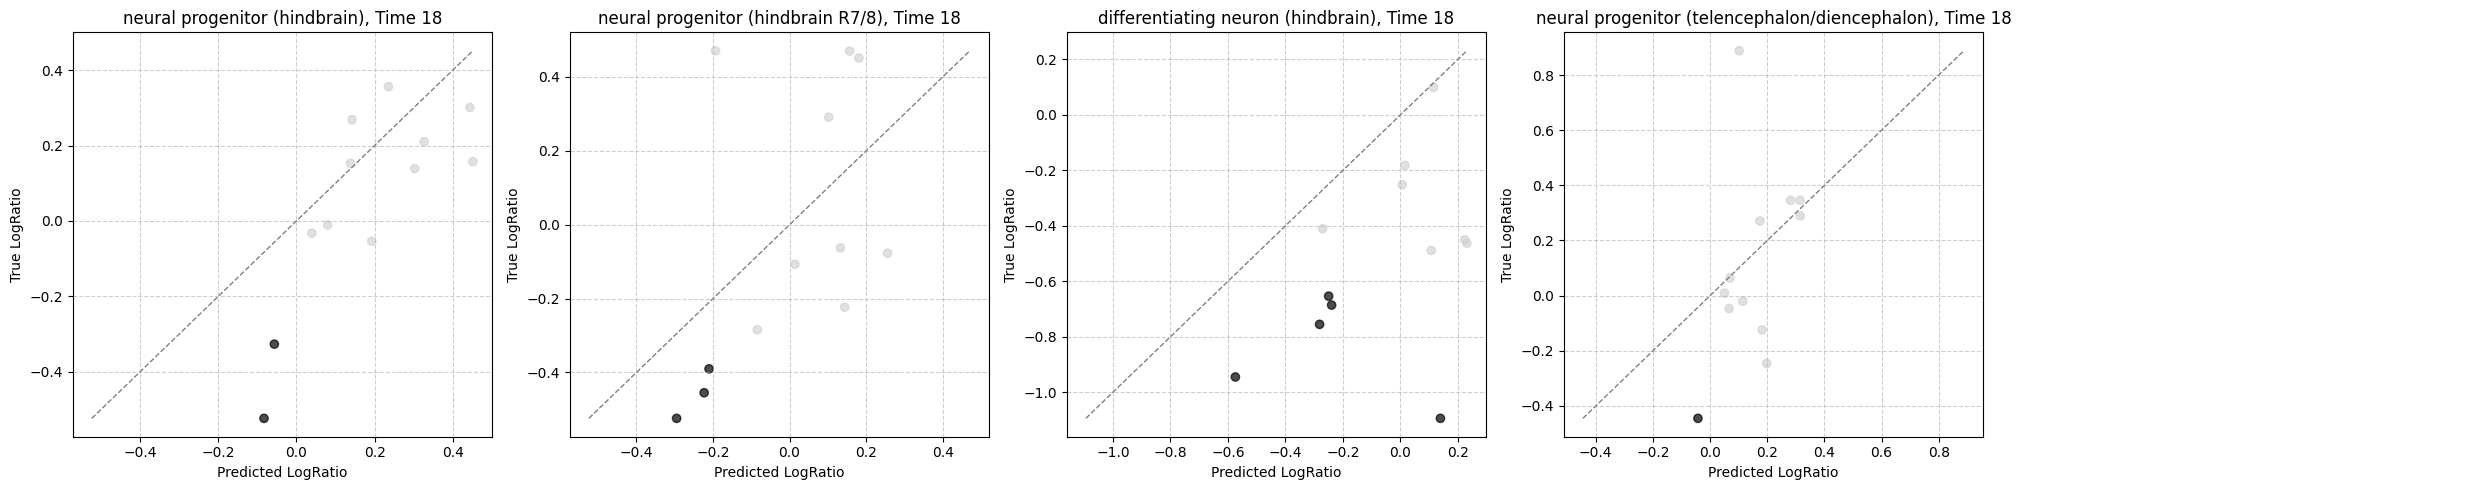

In [29]:
import numpy as np
import matplotlib.pyplot as plt

cts_selected = cts_red
timepoint = 18

# Determine number of rows needed for 5 plots per row
n_plots = len(cts_selected)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Round up division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()  # Flatten axes array for easy iteration

for idx, cell_type in enumerate(cts_selected):
    df_red = df[(df["cell_type_broad_transfer"] == cell_type) & (df["timepoint"] == timepoint)]

    if df_red.empty:
        print(f"No data for {cell_type} at timepoint {timepoint}")
        axes[idx].axis("off")  # Hide empty subplot
        continue

    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")

    # Scatter plot
    axes[idx].scatter(
        df_red["logratio_pred"], df_red["logratio_true"], 
        alpha=0.7, edgecolors="face", c=colors
    )

    # Add diagonal reference line
    finite_pred = df_red["logratio_pred"].replace([np.inf, -np.inf], np.nan).dropna()
    finite_true = df_red["logratio_true"].replace([np.inf, -np.inf], np.nan).dropna()

    if not finite_pred.empty and not finite_true.empty:
        minimum = min(finite_pred.min(), finite_true.min())
        maximum = max(finite_pred.max(), finite_true.max())

        axes[idx].plot(
            [minimum, maximum], [minimum, maximum], 
            linestyle="--", color="gray", linewidth=1
        )

    # Labels and title
    axes[idx].set_xlabel("Predicted LogRatio")
    axes[idx].set_ylabel("True LogRatio")
    axes[idx].set_title(f"{cell_type}, Time {timepoint}")

    # Grid styling
    axes[idx].grid(True, linestyle="--", alpha=0.6)

# Turn off unused subplots (if any)
for i in range(n_plots, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


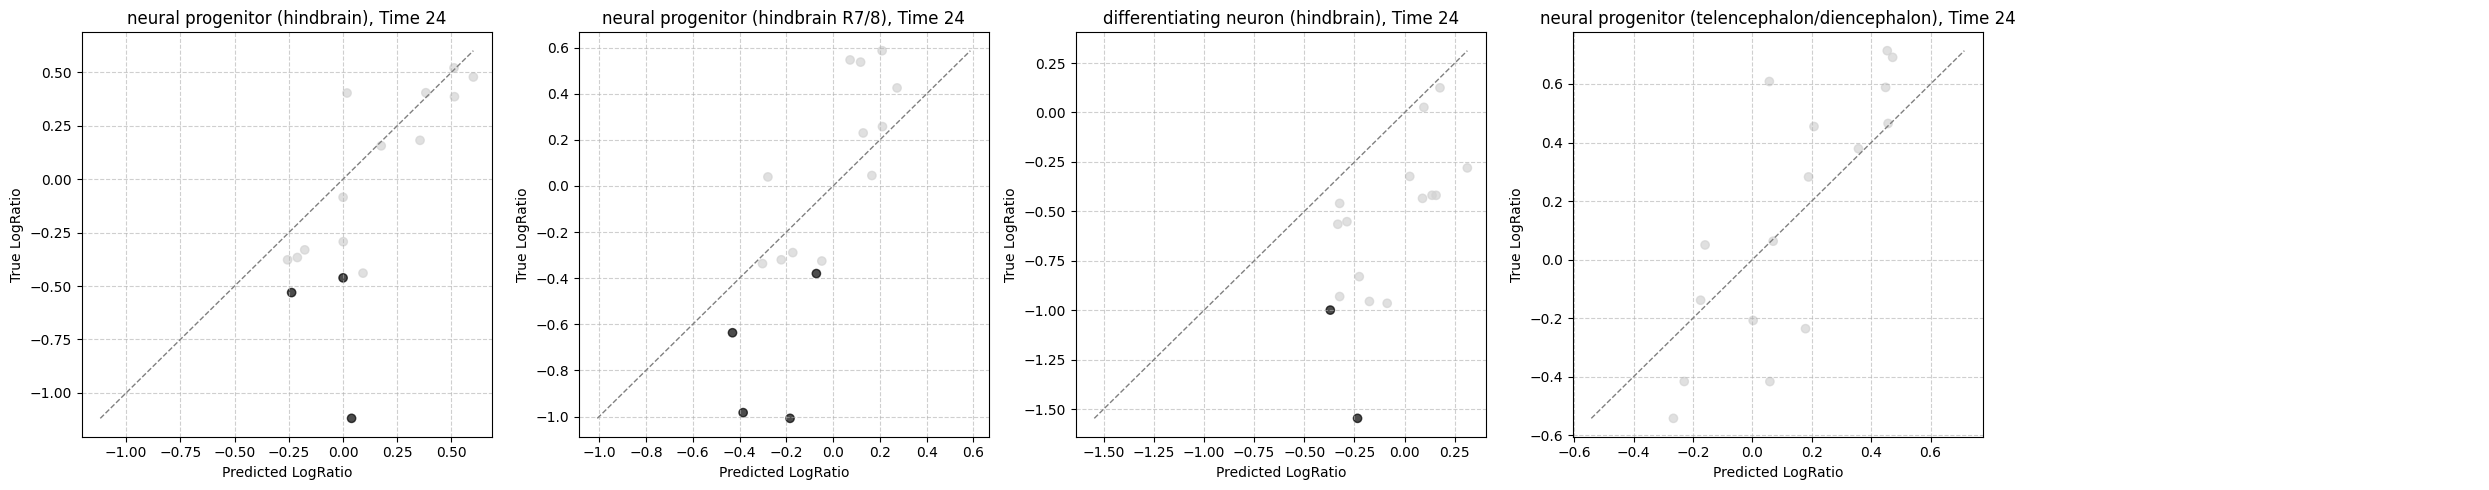

In [28]:
import numpy as np
import matplotlib.pyplot as plt

cts_selected = cts_red
timepoint = 24

# Determine number of rows needed for 5 plots per row
n_plots = len(cts_selected)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Round up division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()  # Flatten axes array for easy iteration

for idx, cell_type in enumerate(cts_selected):
    df_red = df[(df["cell_type_broad_transfer"] == cell_type) & (df["timepoint"] == timepoint)]

    if df_red.empty:
        print(f"No data for {cell_type} at timepoint {timepoint}")
        axes[idx].axis("off")  # Hide empty subplot
        continue

    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")

    # Scatter plot
    axes[idx].scatter(
        df_red["logratio_pred"], df_red["logratio_true"], 
        alpha=0.7, edgecolors="face", c=colors
    )

    # Add diagonal reference line
    finite_pred = df_red["logratio_pred"].replace([np.inf, -np.inf], np.nan).dropna()
    finite_true = df_red["logratio_true"].replace([np.inf, -np.inf], np.nan).dropna()

    if not finite_pred.empty and not finite_true.empty:
        minimum = min(finite_pred.min(), finite_true.min())
        maximum = max(finite_pred.max(), finite_true.max())

        axes[idx].plot(
            [minimum, maximum], [minimum, maximum], 
            linestyle="--", color="gray", linewidth=1
        )

    # Labels and title
    axes[idx].set_xlabel("Predicted LogRatio")
    axes[idx].set_ylabel("True LogRatio")
    axes[idx].set_title(f"{cell_type}, Time {timepoint}")

    # Grid styling
    axes[idx].grid(True, linestyle="--", alpha=0.6)

# Turn off unused subplots (if any)
for i in range(n_plots, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


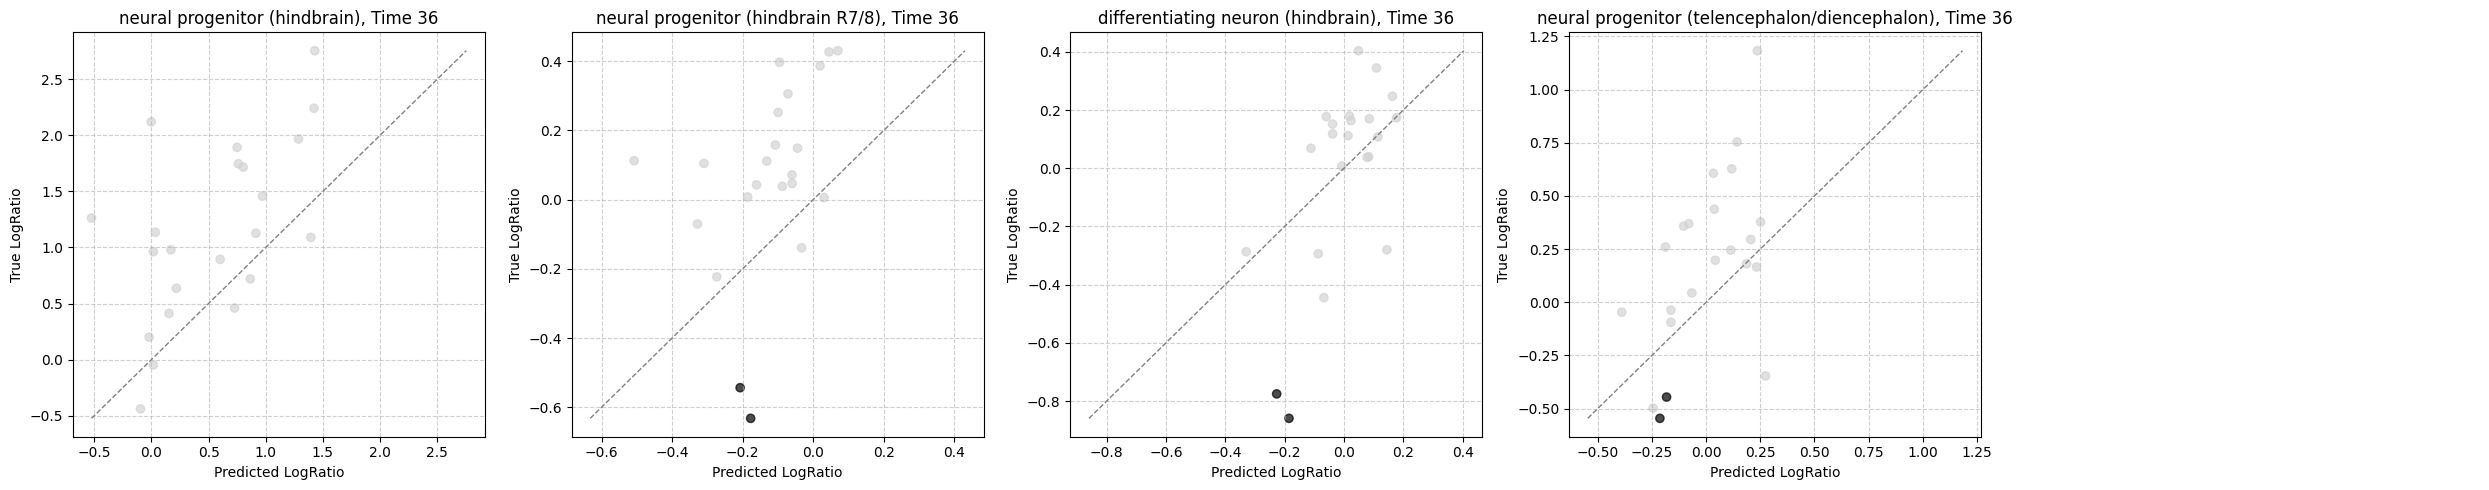

In [31]:
import numpy as np
import matplotlib.pyplot as plt

cts_selected = cts_red
timepoint = 36

# Determine number of rows needed for 5 plots per row
n_plots = len(cts_selected)
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols  # Round up division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()  # Flatten axes array for easy iteration

for idx, cell_type in enumerate(cts_selected):
    df_red = df[(df["cell_type_broad_transfer"] == cell_type) & (df["timepoint"] == timepoint)]

    if df_red.empty:
        print(f"No data for {cell_type} at timepoint {timepoint}")
        axes[idx].axis("off")  # Hide empty subplot
        continue

    # Assign colors based on significance
    colors = np.where(df_red["is_significant"], "black", "lightgray")

    # Scatter plot
    axes[idx].scatter(
        df_red["logratio_pred"], df_red["logratio_true"], 
        alpha=0.7, edgecolors="face", c=colors
    )

    # Add diagonal reference line
    finite_pred = df_red["logratio_pred"].replace([np.inf, -np.inf], np.nan).dropna()
    finite_true = df_red["logratio_true"].replace([np.inf, -np.inf], np.nan).dropna()

    if not finite_pred.empty and not finite_true.empty:
        minimum = min(finite_pred.min(), finite_true.min())
        maximum = max(finite_pred.max(), finite_true.max())

        axes[idx].plot(
            [minimum, maximum], [minimum, maximum], 
            linestyle="--", color="gray", linewidth=1
        )

    # Labels and title
    axes[idx].set_xlabel("Predicted LogRatio")
    axes[idx].set_ylabel("True LogRatio")
    axes[idx].set_title(f"{cell_type}, Time {timepoint}")

    # Grid styling
    axes[idx].grid(True, linestyle="--", alpha=0.6)

# Turn off unused subplots (if any)
for i in range(n_plots, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


In [32]:
df.shape

(1136, 9)

In [38]:
df["condition"].value_counts()

condition
zc4h2_control_24     16
wnt3a_wnt8_18        16
hand2_control_36     16
tfap2a_foxd3_48      16
foxd3_control_36     16
                     ..
tbx16_tbx16l_24      16
tfap2a_foxd3_36      16
hoxb1a_control_48    16
zc4h2_control_36     16
hoxb1a_control_24    16
Name: count, Length: 71, dtype: int64

In [40]:
df["timepoint"].value_counts()

timepoint
36    352
24    256
48    240
18    192
72     96
Name: count, dtype: int64

In [39]:
df

cell_type_broad_transfer  ratio_pred  ratio_true  \
3                    neural progenitor (hindbrain)    0.864279    0.775667   
9                          neural progenitor (MHB)    0.882728    0.926040   
11              neural progenitor (hindbrain R7/8)    0.824383    1.027538   
14  neural progenitor (telencephalon/diencephalon)    0.853053    0.749336   
22  neurons (differentiating, contains peripheral)    0.987985    0.975296   
..                                             ...         ...         ...   
54   neuron (cranial ganglia sensory, Rohon-Beard)    1.174185    1.471093   
55                        differentiating neuron 2    1.085640    0.862072   
62           neuron (telencephalon, glutamatergic)    1.212306    0.928678   
69                                       KA neuron    0.882634    1.149429   
84                           neuron (dopaminergic)    1.153729    1.252057   

    logratio_true  logratio_pred          condition  significance  \
3       -0.366491      -0.210431   zc4h2_control_24     36.111111   
9       -0.110854      -0.179958   zc4h2_control_24     47.222222   
11       0.039191      -0.278613   zc4h2_control_24     69.444444   
14      -0.416316      -0.229293   zc4h2_control_24     36.111111   
22      -0.036088      -0.017439   zc4h2_control_24     52.777778   
..            ...            ...                ...           ...   
54       0.556888       0.231659  hoxb1a_control_24     86.111111   
55      -0.214120       0.118545  hoxb1a_control_24     44.444444   
62      -0.106750       0.277754  hoxb1a_control_24     48.484848   
69       0.200918      -0.180113  hoxb1a_control_24     65.714286   
84       0.324300       0.206304  hoxb1a_control_24     70.000000   

    is_significant  timepoint  
3            False         24  
9            False         24  
11           False         24  
14           False         24  
22           False         24  
..             ...        ...  
54           False         24  
55           False         24  
62           False         24  
69           False         24  
84           False         24  

[1136 rows x 9 columns]

In [42]:
df_all.head()

cell_type_broad_transfer  ratio_pred  ratio_true  \
0                              periderm    1.182168    1.349712   
1                    mature fast muscle    1.177825    1.242196   
2  connective tissue-meninges-dermal FB    1.046386    0.899433   
3         neural progenitor (hindbrain)    0.864279    0.775667   
4                    mature slow muscle    0.975546    1.205383   

   logratio_true  logratio_pred         condition  
0       0.432652       0.241436  zc4h2_control_24  
1       0.312892       0.236125  zc4h2_control_24  
2      -0.152912       0.065415  zc4h2_control_24  
3      -0.366491      -0.210431  zc4h2_control_24  
4       0.269492      -0.035718  zc4h2_control_24

In [46]:
spearman_corrs = {}
pearson_corrs = {}
max_logratios = {}
dfs = []
for ood_cond in ood_conditions:
    csv_file = [el for el in os.listdir(data_dir) if ((ood_cond in el) and ("csv" in el))]
    if len(csv_file)==0:
        continue
    assert len(csv_file) == 1
    df = pd.read_csv(os.path.join(data_dir, csv_file[0]))
    spearman_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    max_logratios[ood_cond] = np.abs(df["logratio_true"]).max()
    df["condition"] = f"{ood_cond}"
    dfs.append(df)

In [47]:
df2 = pd.concat(dfs)

In [48]:
df2.shape

(7171, 6)

<Axes: >

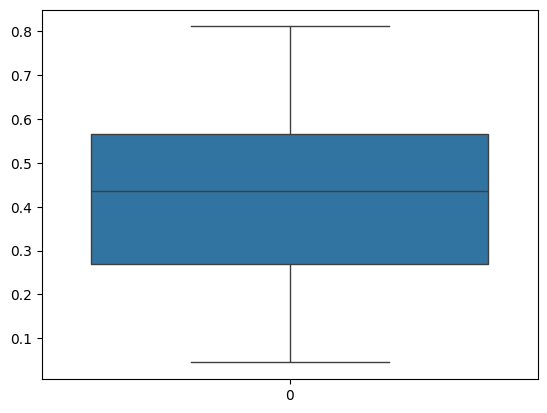

In [55]:
import seaborn as sns
sns.boxplot(spearman_corrs.values())
# A

<Axes: >

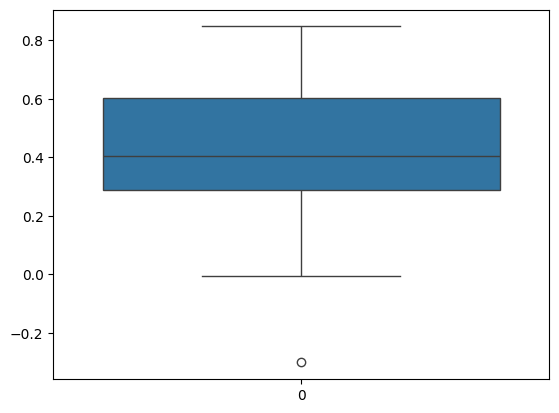

In [56]:
sns.boxplot(pearson_corrs.values())

In [50]:
df2["condition"].value_counts()

condition
zc4h2_control_24     101
wnt3a_wnt8_18        101
hand2_control_36     101
tfap2a_foxd3_48      101
foxd3_control_36     101
                    ... 
tbx16_tbx16l_24      101
tfap2a_foxd3_36      101
hoxb1a_control_48    101
zc4h2_control_36     101
hoxb1a_control_24    101
Name: count, Length: 71, dtype: int64

In [ ]:
# reverse filtering: for one knockout , how much does a cell type vary?